<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/google_colab_examples/dssat_spatial_crop_simulation_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to perform a spatial crop simulation at a pixel-scale resolution using the WeatherSoilDataProcessor library and the DSSAT model. It covers downloading necessary spatial data (weather and soil), creating data cubes, and running the crop model simulation.

In [ ]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

import os
os.chdir('/content/WeatherSoilDataProcessor')

!pip install -r /content/WeatherSoilDataProcessor/requirements.txt

In [ ]:
!pip install hvplot panel param geoviews bokeh jupyter_bokeh -U
from google.colab import output
output.enable_custom_widget_manager()

# Run Spatial Crop Simulation at Pixel-Scale Resolution

This example demonstrates how to simulate the potential yield of a specific crop at a fine spatial resolution (250m), aligning with the SoilGrids project resolution. The simulation requires detailed information on soil and weather conditions, as well as specified management practices.

## Repository Structure

The repository is organized into three main components:

1. [**Download Spatial Data:**](#downloaddata)  
   - Weather Data
   - Soil Data

2. [**Data Cube Creation:**](#datacube)
   - Set configuration parameters
   - Spatial visualization
   - Export data as NetCDF files

3. [**Crop Modeling Using the DSSAT Model:**](#cropmodel)
   - Configuration file setup
   - Running DSSAT
   - Plotting the results

## 1. Download Spatial Data<a id="downloaddata"></a>


### Weather Data

In this section, we will download historical weather data. The information will be downloaded mainly from two sources: [CHIRPS](https://www.chc.ucsb.edu/data/chirps) and [AgERA5](https://cds.climate.copernicus.eu/datasets/sis-agrometeorological-indicators?tab=overview).

To access AgERA5 data, users must provide account credentials. This requires two key pieces of information:

- Email: The email address used to register the AgERA5 account.
- API Code: A unique code available in the profile settings after account creation.

The following command is used to authenticate and access AgERA5 data:

In [ ]:
YOURUSERAPICODE = '06d3e721-5caf-4603-87ce-4a20dac9b6aa'#
YOUREMAIL = 'andres.aguilar@cgiar.org'

with open("/root/.cdsapirc", "w") as f:
  f.write("url: https://cds.climate.copernicus.eu/api\nkey: {}\nemail: ".format(YOURUSERAPICODE, YOUREMAIL))

Afterward, we set the configuration dictionary that defines the parameters for the weather data download, such as the time period, geographical extent, and the output folder path.

In [ ]:
import os
os.chdir('/content/WeatherSoilDataProcessor')

import geopandas as gpd
from omegaconf import OmegaConf

from spatialdata.climate_data import MLTWeatherDataCube, ClimateDataDownload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {
    'DATES': {
        'starting_date':'2000-01-01', # Start date for weather data download
        'ending_date': '2019-12-31'}, # End date for weather data download
    'SPATIAL_INFO': {
          'spatial_file': None, # Path to a spatial file (e.g., shapefile) to define the extent
          'extent': None # List of [min_lon, min_lat, max_lon, max_lat] to define the extent
    },
    'WEATHER': { ## weather information
        'variables': { # variables to download
              'precipitation': {'mission': 'chirps', 'source': 'chirps'},
              'solar_radiation': {'mission': 'agera5', 'source': 'agera5'},
              'temperature_tmax': {'mission': 'agera5', 'source': 'agera5'},
              'temperature_tmin': {'mission': 'agera5', 'source': 'agera5'}
        },
    },
    'GENERAL': {
        'suffix': "mwi",   # ISO3 code for the country of interest
        'ncores': 10, # Number of cores to use for parallel processing (0 means use all available cores)
    },
    'PATHS':{
        'output_path': 'weather/' # Folder path to save the downloaded weather data
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': None, 'extent': None}

In [ ]:
import requests

if config.SPATIAL_INFO.get('spatial_file',None):
  extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), round_numbers = True)
elif config.GENERAL.get('suffix', None):
  country = config.GENERAL.suffix.upper()
  boundary_type = 'ADM0'
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/{boundary_type}/"
  meta = requests.get(url).json()
  extent = get_boundaries_from_path(meta["gjDownloadURL"], round_numbers = True)

else:
    extent = config.SPATIAL_INFO.extent

print(f"from {config.DATES.starting_date} to {config.DATES.ending_date}" )
climatedata = ClimateDataDownload(starting_date= config.DATES.starting_date,
                                    ending_date= config.DATES.ending_date,
                                    xyxy= extent,
                                    output_folder= config.PATHS.output_path)

climatedata.download_weather_information(config.WEATHER.variables, suffix_output_folder=config.GENERAL.suffix, ncores = config.GENERAL.ncores)

### Soil Data

In this section, we will download soil data information for different depths. Currently, the information is downloaded from the [SoilGrids](https://soilgrids.org/) project. SoilGrids provides global gridded soil information at a resolution of 250 meters. The data includes various soil properties at different depths, which are crucial inputs for crop modeling.

In [ ]:
from spatialdata.soil_data import SoilGridDataDonwload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {

    'SPATIAL_INFO': {
          'spatial_file': None,
          'extent': None,
          'crs': 'ESRI:54052' ## soilgrids projection system
    },
    'SOIL': {
          'variables': ["clay",  "sand", "silt", "cec", "bdod", "cfvo", "nitrogen", "phh2o", "soc","wv0010","wv0033", "wv1500"],
          'depths': ["0-5","5-15","15-30","30-60"]
    },
    'GENERAL': {
        'suffix': 'mwi'   # ISO3 country code
    },
    'PATHS':{
        'output_path': 'soil/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': None, 'extent': None, 'crs': 'ESRI:54052'}

In [ ]:

if config.SPATIAL_INFO.get('spatial_file',None):
  extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), crs = config.SPATIAL_INFO.crs, round_numbers = True)
elif config.GENERAL.get('suffix', None):
  country = config.GENERAL.suffix.upper()
  boundary_type = 'ADM0'
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/{boundary_type}/"
  meta = requests.get(url).json()
  extent = get_boundaries_from_path(meta["gjDownloadURL"],crs = config.SPATIAL_INFO.crs, round_numbers = True)

else:
    extent = config.SPATIAL_INFO.extent


outputpath = os.path.join(config.PATHS.output_path, config.GENERAL.suffix)

soildata = SoilGridDataDonwload(soil_layers= config.SOIL.variables,
                            depths= config.SOIL.depths,
                            output_folder= outputpath)

soildata.download_soilgrid(boundaries= extent)

## 2. Data Cube Creation<a id="datacube"></a>

### Set configuration parameters
To implement this, it is necessary to have spatial information for soil and climate. We can create a datacube with dimensions height, width, channel, and date for weather, and height, width, channel, and depth for soil.

An example of the spatial configuration is available in the options folder. Here, we will define it as a dictionary variable.

In [5]:
import os
import requests
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from crop_modeling.spatial_process import SpatialData
warnings.filterwarnings("ignore", category=DeprecationWarning)

os.chdir('/content/WeatherSoilDataProcessor')



In [6]:
## Configuration for creating spatial data cubes

configuration_info = {
    'GENERAL_INFO': {
        'projected_crs':'ESRI:54052',  # Projected Coordinate System for spatial data
        'suffix': 'mwi',  # Suffix used for output files, ISO3 country code
        'ncores': 10
    },
    'SPATIAL_VECTOR': {
        # 'boundaries': "data/country.shp", # Optional: Path to a geospatial file defining spatial boundaries
        'boundaries': None  # Set to None to download boundaries based on country code
    },
    'WEATHER': {  # Weather data configuration
        'setup_parameters': {  # Parameters for creating the weather data cube
            'paths':{  # Paths to raw meteorological variable data
                'precipitation': "weather/precipitation_hnd_raw",
                'srad': "weather/solar_radiation_hnd_raw",
                'tmax': "weather/temperature_tmax_hnd_raw",
                'tmin': "weather/temperature_tmin_hnd_raw"
            },
            'crs': 'EPSG:4326',  # Spatial Coordinate System for weather data
            'period': ['2000-01-01', '2019-12-31'] ,  # Time period for weather data
            'reference_variable': 'precipitation'  # Variable used as spatial resolution reference
        },
        'data_cube_path' : None  # Optional: Path to an existing weather data cube NetCDF file
    },
    'SOIL': {  # Soil data configuration
        'setup_parameters': {  # Parameters for creating the soil data cube
            'path': "soil/hnd/",  # Path to raw soil data
            'variables': ["clay",  "sand", "silt", "cec", "bdod", "cfvo", "nitrogen", "phh2o", "soc","wv0010","wv0033", "wv1500"],  # Soil variables to include
            'depths': ["0-5","5-15","15-30","30-60"],  # Soil depths to include
            'crs': 'ESRI:54052',  # Spatial Coordinate System for SoilGrids data
            'reference_variable': 'sand'  # Variable used as spatial resolution reference
        },
        'data_cube_path' : None  # Optional: Path to an existing soil data cube NetCDF file
    }
}

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
## creating boundaries file if there is not one
import geopandas as gpd
if configuration_info['SPATIAL_VECTOR'].get('boundaries', None) is None:
  country = configuration_info['GENERAL_INFO']['suffix'].upper()
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/ADM0/"
  meta = requests.get(url).json()
  data_country = gpd.read_file(meta["gjDownloadURL"])
  cs = configuration_info['GENERAL_INFO']['suffix']
  data_country.to_file(f'data/country_{cs}.shp')
  configuration_info['SPATIAL_VECTOR']['boundaries'] = f'data/country_{cs}.shp'
  print(cs)
  configuration_info['WEATHER']['setup_parameters']['paths']['precipitation'] = f"weather/precipitation_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['srad'] = f"weather/solar_radiation_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['tmax'] = f"weather/temperature_tmax_{cs}_raw"
  configuration_info['WEATHER']['setup_parameters']['paths']['tmin'] = f"weather/temperature_tmin_{cs}_raw"
  configuration_info['SOIL']['setup_parameters']['path'] = f"soil/{cs}"


mwi


In [ ]:

# Initialize SpatialData with the configuration dictionary
spdata = SpatialData(configuration_dict=configuration_info)

# Retrieve climate data
spdata.get_climate_data()


weather/precipitation_mwi_raw/2000
weather/precipitation_mwi_raw/2001
weather/precipitation_mwi_raw/2002
weather/precipitation_mwi_raw/2003
weather/precipitation_mwi_raw/2004
weather/precipitation_mwi_raw/2005
weather/precipitation_mwi_raw/2006
weather/precipitation_mwi_raw/2007
weather/precipitation_mwi_raw/2008
weather/precipitation_mwi_raw/2009
weather/precipitation_mwi_raw/2010
weather/precipitation_mwi_raw/2011
weather/precipitation_mwi_raw/2012
weather/precipitation_mwi_raw/2013
weather/precipitation_mwi_raw/2014
weather/precipitation_mwi_raw/2015
weather/precipitation_mwi_raw/2016
weather/precipitation_mwi_raw/2017
weather/precipitation_mwi_raw/2018
weather/precipitation_mwi_raw/2019
weather/solar_radiation_mwi_raw/2000
weather/solar_radiation_mwi_raw/2001
weather/solar_radiation_mwi_raw/2002
weather/solar_radiation_mwi_raw/2003
weather/solar_radiation_mwi_raw/2004
weather/solar_radiation_mwi_raw/2005
weather/solar_radiation_mwi_raw/2006
weather/solar_radiation_mwi_raw/2007
weat

100%|██████████| 7305/7305 [00:03<00:00, 1853.70it/s]


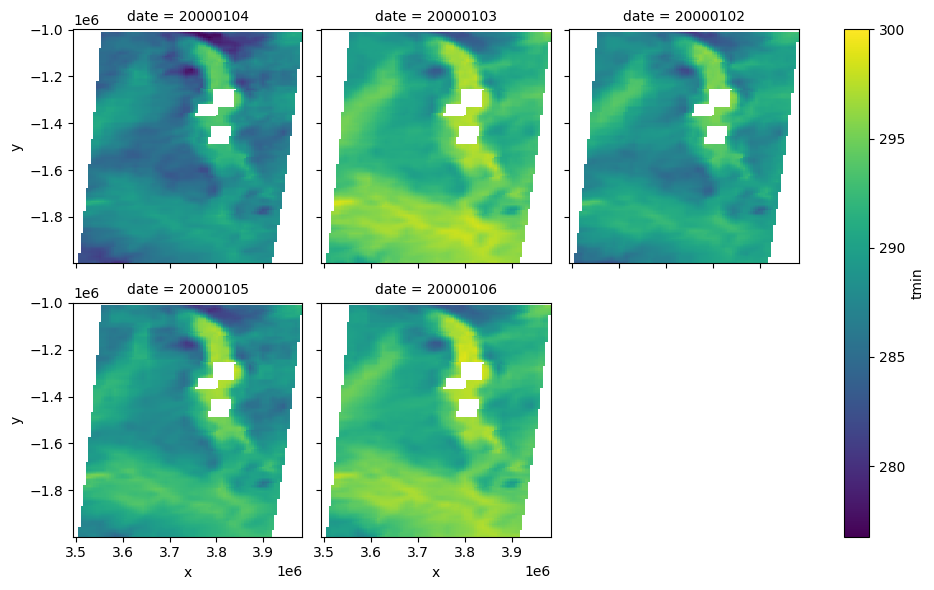

In [ ]:
## plots

g_simple = spdata.climate.tmin.isel(date = list(range(5))).plot(x="x", y="y", col="date", col_wrap=3, vmax = 300)

In [ ]:
init_year = configuration_info['WEATHER']['setup_parameters']['period'][0].split('-')[0]
ending_year = configuration_info['WEATHER']['setup_parameters']['period'][1].split('-')[0]
climate_path = f'weather/weather_{cs}_{init_year}_{ending_year}.nc'
spdata._save_asnc(spdata.climate, fn = climate_path)

In [ ]:
spdata.climate = None

In [ ]:

# Retrieve soil data
spdata.get_soil_data()

# texture values in soil grids data is multiply by 10
g_simple = spdata.soil.clay.plot(x="x", y="y", col="depth", col_wrap=2, vmax = 600)

In [ ]:
# save data as datacubes
soil_path = f'soil/soil_{cs}.nc'
spdata._save_asnc(spdata.soil, fn = soil_path)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
cs = configuration_info['GENERAL_INFO']['suffix']
source_file = f'/content/WeatherSoilDataProcessor/weather/weather_{cs}_{init_year}_{ending_year}.nc'
destination_folder = '/content/drive/MyDrive/CIAT/agwise'

shutil.copy2(source_file, destination_folder)

source_file = f'/content/WeatherSoilDataProcessor/soil/soil_{cs}.nc'
destination_folder = '/content/drive/MyDrive/CIAT/agwise'
shutil.copy2(source_file, destination_folder)


'/content/drive/MyDrive/CIAT/agwise/weather_mwi_2000_2019.nc'

## 3. Crop Modeling Using the DSSAT Model<a id="cropmodel"></a>




### Spatial data

The previous steps serve as a guide for obtaining the spatial datacubes data, (climate, and weather). In the following example, we will use datacubes that were previously processed for the entire country. These files contain historical climate data spanning a 34-year period. They are available in a Google Drive folder, so you will only need to download them using the gdown function.


In [7]:
import os
soil_fileid = '1_z2BOjCHuyG13rwPTMzSFfXNzmIHdh2x'
weather_fileid = '1eQydlvf4uZV-36zkvjZgHYcLsrlK4Qsz'


init_year = configuration_info['WEATHER']['setup_parameters']['period'][0].split('-')[0]
ending_year = configuration_info['WEATHER']['setup_parameters']['period'][1].split('-')[0]
climate_path = f'weather/weather_{cs}_{init_year}_{ending_year}.nc'
if not os.path.exists(os.path.dirname(climate_path)): os.mkdir(os.path.dirname(climate_path))

soil_path = f'soil/soil_{cs}.nc'
if not os.path.exists(os.path.dirname(soil_path)): os.mkdir(os.path.dirname(soil_path))

if not os.path.exists(climate_path):
  !gdown --id {soil_fileid} --output {climate_path}

if not os.path.exists(soil_path):
  !gdown --id {weather_fileid} --output {soil_path}

### Configuration file setup

To specify that the analysis will be done at pixel-scale, we set 'pixel' in the configuration dictionary.

Other parameters to configure include crop parameters and management practices.
Below is an example of how to define these parameters. For more examples, please check the options/dssat_options folder.

In [9]:
import os
os.chdir('/content/WeatherSoilDataProcessor')
from crop_modeling.spatial_process import SpatialCM
import numpy as np
import pandas as pd
import geopandas as gpd

cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Malawi',
        'country_code': 'MWI', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 15,
        'model': 'dssat',
        'bin_path': None
    },
    'SPATIAL_INFO':{
        'geospatial_path': None, # spatial file that contains the region of interest
        'feature_name': 'shapeName', ## an unique code that represent each region of interest
        'adm_level': 2,
        'aggregate_by' : 'pixel',
        'soil_path' : soil_path,
        'weather_path': climate_path,
        'scale_factor': 5 # scale factor for soil and weather spatial resolution combination. the scale resample is applied to the climate datacube 5 times represents ~1km
    },
    'CROP': {
        'name': 'Maize', # crop name
        'cultivar': 'IB1072', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '1991-03-01',
        'harvesting_date': None,
        'plantingWindow': 30, # planting window in weeks
        'fertilizer_schedule': {
            'days_after_planting': None,
            'npk': None
        },
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/KEAG8104.MZX'
    }
}



### Running DSSAT

In [15]:
## get the spatial boundaries if the file is not provided
cs = cm_configuration['GENERAL_INFO']['country_code'].upper()

if cm_configuration['SPATIAL_INFO'].get('geospatial_path', None) is None:

  adm_level = cm_configuration['SPATIAL_INFO']['adm_level']
  url = f"https://www.geoboundaries.org/api/current/gbOpen/{cs}/ADM{adm_level}/"

  gpd.read_file(requests.get(url).json()["gjDownloadURL"]).to_file(f'data/country_{cs}_ADM{adm_level}.shp')
  cm_configuration['SPATIAL_INFO']['geospatial_path'] = f'data/country_{cs}_ADM{adm_level}.shp'


In [25]:
# Initialize the spatial crop modeling class
cm_sp = SpatialCM(configuration_dict=cm_configuration)
feat_attr = cm_configuration['SPATIAL_INFO'].get('feature_name', None)
geocode = 'Zomba'
# Specify the region of interest by its geocode this can be also done using the feature index
roi = cm_sp.geo_features.loc[cm_sp.geo_features[feat_attr]==str(geocode)]
roi_name = roi[cm_sp.config.SPATIAL_INFO.feature_name].values[0]
roi
#cm_sp.geo_features['GEOCODIGO']

loaded from soil/soil_mwi.nc
loaded from weather/weather_mwi_2000_2019.nc


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
27,Zomba,None,42251766B13881881574545,MWI,ADM2,"POLYGON ((35.03997 -15.32181, 35.04045 -15.321..."


<Axes: >

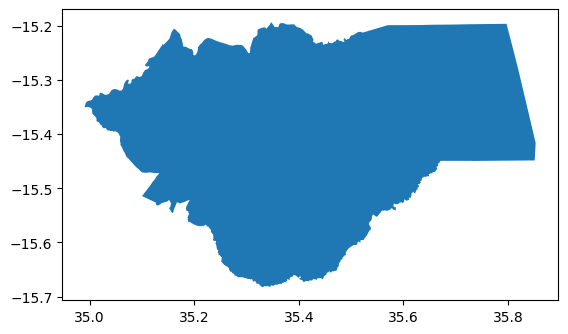

In [26]:
roi.plot()

In [27]:

import shutil
if os.path.exists(f'/content/WeatherSoilDataProcessor/runs/{geocode}'):
  shutil.rmtree(f'/content/WeatherSoilDataProcessor/runs/{geocode}', ignore_errors=False, onerror=None)

In [ ]:
cm_sp.set_up_folders(site = roi_name)

# Create soil and weather files for the selected region
workingpath = cm_sp.create_roi_sp_data(
    roi= roi,
    export_spatial_data= True
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.model.find_envworking_paths(cm_sp._tmp_path, 'WTH')

    # Set up crop files
    cm_sp.model.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.model.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)

    # run the simulation
    dssath_path = cm_sp.config.GENERAL_INFO.get('dssat_path', None)
    completed_sims =cm_sp.model.run(cm_sp.model.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                                    ncores = cm_sp.config.GENERAL_INFO.ncores,
                                        bin_path = cm_sp.config.GENERAL_INFO.bin_path, remove_tmp_folder=True)
    print(completed_sims)
else:
    print('there is no information')

100%|██████████| 51/51 [01:11<00:00,  1.41s/it]


Configuration file written: runs/150149/114/experimental_file_config.yaml
experimental file created: ['runs/150149/114/EXPS0001.MZX']
Configuration file written: runs/150149/100/experimental_file_config.yaml
experimental file created: ['runs/150149/100/EXPS0001.MZX']
Configuration file written: runs/150149/113/experimental_file_config.yaml
experimental file created: ['runs/150149/113/EXPS0001.MZX']
Configuration file written: runs/150149/93/experimental_file_config.yaml
experimental file created: ['runs/150149/93/EXPS0001.MZX']
Configuration file written: runs/150149/127/experimental_file_config.yaml
experimental file created: ['runs/150149/127/EXPS0001.MZX']
Configuration file written: runs/150149/116/experimental_file_config.yaml
experimental file created: ['runs/150149/116/EXPS0001.MZX']
Configuration file written: runs/150149/85/experimental_file_config.yaml
experimental file created: ['runs/150149/85/EXPS0001.MZX']
Configuration file written: runs/150149/111/experimental_file_conf

  2%|▏         | 1/51 [00:36<30:20, 36.41s/it]

### Crop simulation outputs

After completing the simulation, the next step is to generate the output maps.


In [ ]:
from crop_modeling.dssat.output import update_dssat_data_using_path
from crop_modeling.spatial_process import create_mlt_yield_raster
import rioxarray as rio
import matplotlib.pyplot as plt


refraster = rio.open_rasterio(os.path.join(cm_sp._tmp_path,'ref_raster.tif'))
model_data = update_dssat_data_using_path(cm_sp._tmp_path)

mlt_pot_yield = create_mlt_yield_raster(refraster, model_data, ycol_name='HWAH')


### Plotting the results

In [ ]:
import hvplot.xarray
import holoviews as hv
import panel as pn

hv.extension("bokeh")
minlim = mlt_pot_yield.HWAH.min().values
maxlim = mlt_pot_yield.HWAH.max().values

mltmap = mlt_pot_yield.HWAH.hvplot.image(x='x', y='y', groupby = 'date',frame_height = 600, frame_width= 400, cmap='YlGnBu', fontscale=1.6, crs='EPSG:4326', tiles = 'EsriImagery', clim=(minlim,maxlim))

dmap_panel = pn.panel(mltmap)
dmap_panel


### Exporting the results

In [ ]:
from crop_modeling.utils.process import get_crs_fromxarray,set_encoding, check_crs_inxrdataset

dcengine = 'netcdf4'
encoding = set_encoding(mlt_pot_yield)
xrdata = check_crs_inxrdataset(mlt_pot_yield)
xrdata.to_netcdf(f'simlations_{geocode}.nc', encoding = encoding, engine = dcengine)



In [ ]:
import hvplot.pandas
boxplot = mlt_pot_yield.HWAH.hvplot.box('HWAH', by=['date'], rot=90, box_fill_color='lightblue', width=1600, height=450).opts(ylim=(1285,9969))
dmap_panel = pn.panel(boxplot)
dmap_panel

In [ ]:
from crop_modeling.utils.output_transforms import summarize_spatial_yields_by_time_window

summ_yield  =summarize_spatial_yields_by_time_window(xrdmlt_pot_yieldata, plantingWindow= 30)
